In [20]:
import os
import json
import pandas as pd
from typing import Dict, Any
from urllib.request import urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely import wkt
import openrouteservice
import polars as pl
import os
from IPython.core.interactiveshell import InteractiveShell

from IPython.display import display_html
InteractiveShell.ast_node_interactivity = "all"

auhouseprices_dir = '../data/raw/auhouseprices/'

In [21]:
# Read each .csv file in the directory into a single polars DataFrame
df = pl.DataFrame({})
for file in os.listdir(auhouseprices_dir):
    if file.endswith('.csv'):
        df = df.vstack(pl.read_csv(auhouseprices_dir + file))


In [22]:
pd = df.to_pandas()
pd = pd.rename(columns={'sold_date': 'Listing date'})

In [23]:
pd['property_type'].unique()

array(['Townhouse', 'house', 'House', 'apartment', 'unit', 'Unit',
       'Apartment', 'townhouse', 'studio', 'villa', 'Acreage',
       'warehouse', 'flat', 'Villa', 'terrace', 'other',
       'acreage-semi-rural', 'alpine', 'duplex-semi-detached', 'Studio',
       'acreage/semi-rural', 'serviced apartment', 'duplex/semi-detached',
       'Duplex', 'Other', 'Terrace', 'Flat', 'Alpine',
       'retirement living', 'Warehouse', 'Land'], dtype=object)

In [24]:
pd.isnull().sum()


unique_id               0
street_name         14186
state                2176
postcode             2176
suburb               2176
property_type           0
address                 0
rent                  902
num_bedrooms         6428
num_bathrooms          51
parking            138741
distance_to_cbd         0
Listing date            0
latitude               32
longitude              32
dtype: int64

In [25]:
# delete rows with negetive rent, or negetive numeric values
pd['rent'] = pd['rent'].fillna(0)
pd = pd[pd['rent'] > 0.0]
pd = pd[pd['num_bedrooms'] > 0.0]
pd = pd[pd['num_bathrooms'] > 0.0]
pd = pd[pd['parking'] >= 0.0]
pd = pd[pd['property_type'] != '']
pd['suburb'] = pd['suburb'].str.lower()
pd['property_type'] = pd['property_type'].str.lower()
pd = pd.drop("street_name", axis=1)
pd = pd[pd['longitude'] != 0.0]
pd = pd[pd['latitude'] != 0.0]

# num_bedrooms	num_bathrooms
# we made an assumption that the an average property would have a bathroom and a bedroom at least


In [26]:

pd = pd[pd['property_type'].isin(['house', 'apartment', 'townhouse', 'unit', 'villa','duplex-semi-detached','duplex','studio','flat','retirement living','serviced apartment'])]

In [27]:
pd.isnull().sum()
len(pd)

unique_id             0
state              1904
postcode           1904
suburb             1904
property_type         0
address               0
rent                  0
num_bedrooms          0
num_bathrooms         0
parking               0
distance_to_cbd       0
Listing date          0
latitude             30
longitude            30
dtype: int64

747895

In [28]:
# rename sold_date to date

pd = pd.dropna(subset=['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking', 'property_type', 'Listing date','longitude', 'latitude','state'])
pd = pd.drop("state", axis=1)


In [29]:
pd.isna().sum()
len(pd)
# pd[pd['street_name'].isna()]

unique_id          0
postcode           0
suburb             0
property_type      0
address            0
rent               0
num_bedrooms       0
num_bathrooms      0
parking            0
distance_to_cbd    0
Listing date       0
latitude           0
longitude          0
dtype: int64

745961

In [30]:
# how to summary for the numetrical values
pd.describe()

,unique_id,postcode,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,latitude,longitude
count,7.459610e+05,745961.000000,7.459610e+05,745961.000000,745961.000000,745961.000000,745961.000000,745961.000000,745961.000000
mean,1.680922e+08,3246.788250,4.469423e+02,2.608160,1.436697,1.539282,42.754623,-37.759472,144.937624
std,1.398927e+08,272.324442,1.220126e+04,1.205669,0.571227,1.245635,173.197223,0.983846,2.415125
min,3.035450e+05,3000.000000,1.000000e+00,1.000000,1.000000,1.000000,0.030000,-41.294499,-123.369898
25%,3.480463e+07,3064.000000,3.200000e+02,2.000000,1.000000,1.000000,8.160000,-37.919545,144.892900
50%,3.990857e+07,3151.000000,3.750000e+02,3.000000,1.000000,1.000000,18.060000,-37.830570,145.002686
75%,3.114834e+08,3226.000000,4.600000e+02,3.000000,2.000000,2.000000,40.290000,-37.751790,145.127956
max,3.320003e+08,3996.000000,8.903856e+06,650.000000,52.000000,410.000000,17034.200000,200.000000,200.000000


In [31]:
# outlier analysis

# graph histogram for rent and zoom in
def plothisto(col,logornot=False):
    if logornot:
        pd[col].apply(np.log).hist(bins=100)
    else:
        pd[col].hist(bins=100)
    plt.show()

# now graph its log


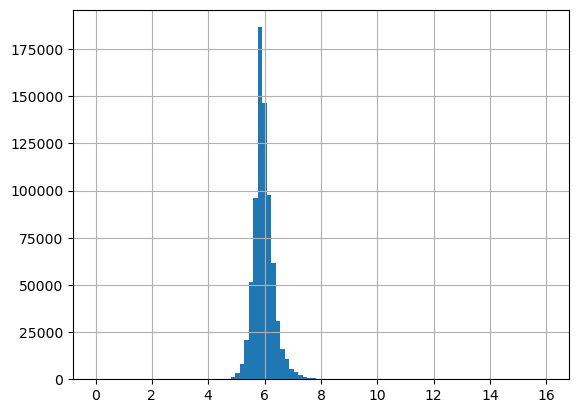

In [32]:
x = 'rent'

plothisto(x,True)

In [33]:
# how to remove to 95 percentile
print(pd['rent'].quantile(0.9999))
print(pd['distance_to_cbd'].quantile(0.9999))
print(pd['num_bedrooms'].quantile(0.9999))
print(pd['num_bathrooms'].quantile(0.9999))
print(pd['parking'].quantile(0.9999))

pd = pd[pd['rent'] < pd['rent'].quantile(0.9999)]
pd = pd[pd['distance_to_cbd'] < pd['distance_to_cbd'].quantile(0.99999)]
pd = pd[pd['num_bedrooms'] < pd['num_bedrooms'].quantile(0.9999)]
pd = pd[pd['num_bathrooms'] < pd['num_bathrooms'].quantile(0.9999)]
pd = pd[pd['parking'] < pd['parking'].quantile(0.9999)]

# pd = pd[pd[x] < pd[x].quantile(0.95)]


4000.0
13184.878039998415
9.0
8.0
12.0


In [34]:
print(pd.isna().sum())
print(len(pd))



unique_id          0
postcode           0
suburb             0
property_type      0
address            0
rent               0
num_bedrooms       0
num_bathrooms      0
parking            0
distance_to_cbd    0
Listing date       0
latitude           0
longitude          0
dtype: int64
745589


In [35]:
pd.describe()

,unique_id,postcode,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,latitude,longitude
count,7.455890e+05,745589.000000,745589.000000,745589.000000,745589.000000,745589.000000,745589.000000,745589.000000,745589.000000
mean,1.680925e+08,3246.758077,419.923896,2.605403,1.435318,1.534045,42.569597,-37.760350,144.939885
std,1.398926e+08,272.308436,193.616409,0.927926,0.558073,0.772311,164.093565,0.947282,2.310488
min,3.035450e+05,3000.000000,1.000000,1.000000,1.000000,1.000000,0.030000,-41.294499,-123.369898
25%,3.480485e+07,3064.000000,320.000000,2.000000,1.000000,1.000000,8.160000,-37.919544,144.892900
50%,3.990860e+07,3151.000000,375.000000,3.000000,1.000000,1.000000,18.060000,-37.830578,145.002670
75%,3.114835e+08,3226.000000,460.000000,3.000000,2.000000,2.000000,40.290000,-37.751804,145.127910
max,3.320003e+08,3996.000000,3850.000000,8.000000,6.000000,11.000000,16913.640000,200.000000,200.000000


In [36]:
pd.to_csv('../data/raw/preprocessing_houseprices.csv', index=False)